In [1]:
import os
import shutil
import pandas as pd

In [2]:
c_file="D:/Project/Datasets/Corneal-Ulcer/dataset/labels.csv"
img_dir="D:/Project/Datasets/Corneal-Ulcer/dataset/images"
n_dir="D:/Project/Datasets/Corneal-Ulcer-detection/Negative"
p_dir="D:/Project/Datasets/Corneal-Ulcer-detection/Positive"

In [3]:
os.makedirs(n_dir, exist_ok=True)
os.makedirs(p_dir, exist_ok=True)

In [4]:
df_imgs=pd.read_csv(c_file)

In [5]:
df_imgs.head()

,name,category,type,grade
0,1.jpg,0,4,3
1,2.jpg,0,4,3
2,3.jpg,0,2,2
3,4.jpg,0,2,1
4,5.jpg,0,1,3


In [6]:
for index,row in df_imgs.iterrows():
    img_name, category=row["name"],row["category"]
    img_path=os.path.join(img_dir,img_name)
    if category==0:
        shutil.move(img_path,os.path.join(n_dir,img_name))
    else:
        shutil.move(img_path, os.path.join(p_dir, img_name))
print("Images categorized")

Images categorized


In [7]:
import matplotlib.pyplot as plt

In [8]:
n_count=len(os.listdir(n_dir))
p_count=len(os.listdir(p_dir))

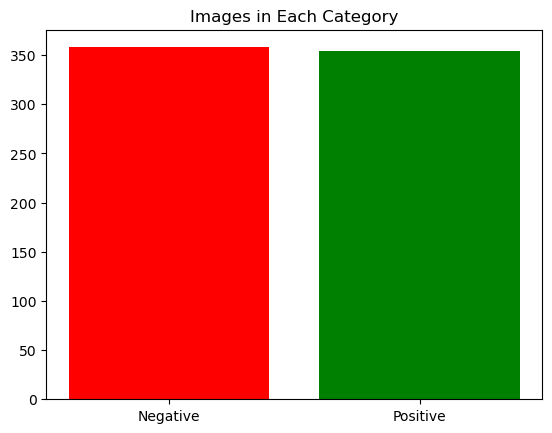

In [9]:
categories=["Negative","Positive"]
counts=[n_count,p_count]
plt.bar(categories,counts,color=["red","green"])
plt.xlabel=('categories')
plt.ylabes=('Number of Images')
plt.title('Images in Each Category')
plt.show()

In [10]:
import splitfolders
import pathlib

In [12]:
base_dir="D:/Project/Datasets/Corneal-Ulcer Detection"
base_dir=pathlib.Path(base_dir)
img_height=1028
img_width=728
batch_size=32
output_path="D:/Project/Datasets/Corneal-Ulcer Detection"
splitfolders.ratio(base_dir,output=output_path,seed=1337,ratio=(.8,.1,.1),group_prefix=None)

Copying files: 712 files [00:16, 43.20 files/s]


In [13]:
train_dir="D:/Project/Datasets/Corneal-Ulcer Detection/train"
val_dir="D:/Project/Datasets/Corneal-Ulcer Detection/val"
test_dir="D:/Project/Datasets/Corneal-Ulcer Detection/test"
img_size=(256,256)
batch_size=32

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout,Input,Lambda, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers, losses
from keras import regularizers

In [16]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)

Found 569 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [17]:
train_generator.class_indices

{'Negative': 0, 'Positive': 1}

In [19]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

In [20]:
optimizer = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 127, 127, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                      

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=int(round(569/32)),
    epochs=150,
    validation_data=validation_generator,
    validation_steps=int(round(70/32))
)

Epoch 1/150
18/18 [==============================] - 57s 3s/step - loss: 12.4310 - accuracy: 0.6520 - val_loss: 14.9132 - val_accuracy: 0.5312
Epoch 2/150
18/18 [==============================] - 56s 3s/step - loss: 11.4666 - accuracy: 0.7012 - val_loss: 14.0889 - val_accuracy: 0.5000
Epoch 3/150
18/18 [==============================] - 57s 3s/step - loss: 10.9891 - accuracy: 0.6749 - val_loss: 19.5431 - val_accuracy: 0.5312
Epoch 4/150
18/18 [==============================] - 56s 3s/step - loss: 10.2364 - accuracy: 0.6872 - val_loss: 24.0972 - val_accuracy: 0.4688
Epoch 5/150
18/18 [==============================] - 50s 3s/step - loss: 9.2185 - accuracy: 0.7469 - val_loss: 17.7937 - val_accuracy: 0.5000
Epoch 6/150
18/18 [==============================] - 46s 3s/step - loss: 8.0566 - accuracy: 0.7311 - val_loss: 15.2337 - val_accuracy: 0.5000
Epoch 7/150
18/18 [==============================] - 47s 3s/step - loss: 7.1525 - accuracy: 0.7399 - val_loss: 13.3000 - val_accuracy: 0.4844
Ep

Epoch 59/150
18/18 [==============================] - 50s 3s/step - loss: 1.1850 - accuracy: 0.8471 - val_loss: 1.2799 - val_accuracy: 0.7656
Epoch 60/150
18/18 [==============================] - 50s 3s/step - loss: 1.1746 - accuracy: 0.8172 - val_loss: 1.1447 - val_accuracy: 0.8750
Epoch 61/150
18/18 [==============================] - 50s 3s/step - loss: 1.1341 - accuracy: 0.8348 - val_loss: 1.2061 - val_accuracy: 0.8281
Epoch 62/150
18/18 [==============================] - 51s 3s/step - loss: 1.1495 - accuracy: 0.8155 - val_loss: 1.1074 - val_accuracy: 0.8594
Epoch 63/150
18/18 [==============================] - 52s 3s/step - loss: 1.0810 - accuracy: 0.8401 - val_loss: 1.2521 - val_accuracy: 0.7500
Epoch 64/150
18/18 [==============================] - 56s 3s/step - loss: 1.0509 - accuracy: 0.8366 - val_loss: 1.1183 - val_accuracy: 0.8281
Epoch 65/150
18/18 [==============================] - 50s 3s/step - loss: 1.0555 - accuracy: 0.8541 - val_loss: 1.1676 - val_accuracy: 0.7656
Epoch 

In [24]:
evaluation = model.evaluate(test_generator)
accuracy = evaluation[1]
print(f"Validation Accuracy: {accuracy}")

3/3 [==============================] - 5s 1s/step - loss: 0.7250 - accuracy: 0.8082
Validation Accuracy: 0.8082191944122314


TypeError: 'str' object is not callable

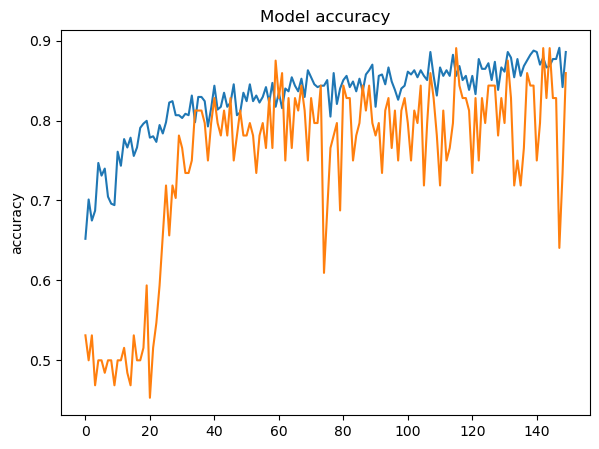

In [25]:
def plot_train_history(history):
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.show()

# Assuming 'history' is the history object returned by model.fit()
plot_train_history(history)


In [26]:
from tensorflow.keras.models import save_model
model_path='D:/Project/ML/corneal_ulcer_model.h5'
save_model(model,model_path)

C:\Users\prath\AppData\Local\Temp\ipykernel_17812\709315445.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model,model_path)


In [27]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np

loaded_model = load_model('D:/Project/ML/corneal_ulcer_model.h5')
print("Corneal Ulcer Detection Model Loaded")

def corneal_ulcer_prediction(test_image_path):
    test_image = load_img(test_image_path, target_size=(256, 256))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    predictions = loaded_model.predict(test_image)

    # Assuming the model outputs a single prediction value (0 or 1) directly
    predicted_class = np.argmax(predictions[0])
    
    if predicted_class == 1:
        print("Corneal Ulcer Detected")
    elif predicted_class == 0:
        print("No Corneal Ulcer Detected")
    
    return predicted_class

Corneal Ulcer Detection Model Loaded
